# Simulation of galactic sources

In [1]:
import simulation ##This function draws sources from spatial distribution with luminosity 1-100GeV
import numpy as np
import makemap
import matplotlib as mpl
c6 = '#e41a1c'
c2 = '#377eb8'
c3 = '#4daf4a'
c4 = '#984ea3'
c5 = '#ff7f00'
c1 = '#66c2a5'
c7 = '#a65628'
c8 = '#f781bf'
c9 = '#999999'
mpl.rcParams['axes.color_cycle'] = [c2,c6,c3,c4,c5,c1,c7,c8,c9]
from matplotlib import gridspec
from matplotlib import rc
rc('font',**{'family':'serif'})
rc('text',usetex=True)
import pylab as plt
%matplotlib inline

/home/mart/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


In [2]:
##Setup some arrays for later
Ebins = np.logspace(0,3,101)
dE = (Ebins[1:]-Ebins[0:-1])
Emean = (Ebins[1:]+Ebins[0:-1])/2.
E3fgl = np.logspace(0,np.log10(200),101)
E3fgl_mean = (E3fgl[1:]+E3fgl[:-1])/2.
mask_E3FGL = (Emean>=1)&(Emean<100)
bins_3fgl = np.logspace(-14,-6,32)
bins_3fgl_mean = (bins_3fgl[1:]+bins_3fgl[0:-1])/2.

## Read 3FGL catalog

In [3]:
##Read 3FGL galactic sources
fl = 'gll_psc_v16.fit'
flux_3fgl,spec_3fgl = simulation.read_catalog(fl,E3fgl_mean,classes=['pwn','spp','snr','psr','lat'])
##'lat' means take also unassociated sources with |b|<5
hist_3fgl = np.histogram(flux_3fgl,bins=bins_3fgl)[0]

In [4]:
flux_3fgl_snr,spec_3fgl_snr = simulation.read_catalog(fl,E3fgl_mean,classes=['pwn','spp','snr'])
##'lat' means take also unassociated sources with |b|<5
hist_3fgl_snr = np.histogram(flux_3fgl_snr,bins=bins_3fgl)[0]

In [5]:
flux_3fgl_psr,spec_3fgl_psr = simulation.read_catalog(fl,E3fgl_mean,classes=['psr'])
##'lat' means take also unassociated sources with |b|<5
hist_3fgl_psr = np.histogram(flux_3fgl_psr,bins=bins_3fgl)[0]

In [6]:
flux_3fgl_ass,spec_3fgl_ass = simulation.read_catalog(fl,E3fgl_mean,classes=['pwn','spp','snr','psr'])
##'lat' means take also unassociated sources with |b|<5
hist_3fgl_ass = np.histogram(flux_3fgl_ass,bins=bins_3fgl)[0]

## Spectrum of 3FGL (galactic sources)

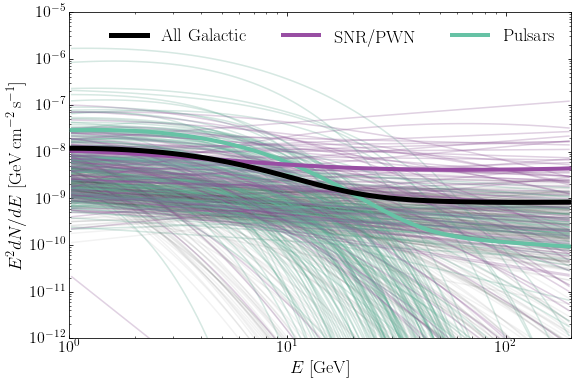

In [7]:
f,ax = plt.subplots(1,figsize=(9,6))
for sp in spec_3fgl:
    ax.loglog(E3fgl_mean,E3fgl_mean**2*sp,alpha=0.05,zorder=1,color='k')

for sp in spec_3fgl_snr:
    ax.loglog(E3fgl_mean,E3fgl_mean**2*sp,alpha=0.2,zorder=3,color=c4)

for sp in spec_3fgl_psr:
    ax.loglog(E3fgl_mean,E3fgl_mean**2*sp,alpha=0.2,zorder=2,color=c1)
    
ax.loglog(E3fgl_mean,E3fgl_mean**2*np.mean(spec_3fgl,axis=0),color='k',alpha=1,lw=5,zorder=10,label='All Galactic')
ax.loglog(E3fgl_mean,E3fgl_mean**2*np.mean(spec_3fgl_snr,axis=0),color=c4,alpha=1,lw=4,zorder=9,label='SNR/PWN')
ax.loglog(E3fgl_mean,E3fgl_mean**2*np.mean(spec_3fgl_psr,axis=0),color=c1,alpha=1,lw=4,zorder=8,label='Pulsars')

ax.set_ylim([1e-12,1e-5])
ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=16)
ax.set_ylabel(r"$E^2 dN/dE$  $\rm [GeV\,cm^{-2} \, s^{-1}]$",fontsize=18)
ax.set_xlabel(r"$E$ [GeV]",fontsize=18)
ax.set_xlim([1,200])
ax.legend(frameon=False,fontsize=18,loc=1,ncol=3)
# plt.savefig('3fgl_spec.pdf',bbox_inches='tight')

## Load the diffuse pion emission as measured with SkyFACT

In [7]:
def log_interp(zz, xx, yy):
    logz = np.log10(zz)
    logx = np.log10(xx)
    logy = np.log10(yy)
    return np.power(10.0, np.interp(logz, logx, logy))

In [8]:
###Diffuse pion

###Load diffuse flux from skyfact fit
###Here load the diffuse flux at different l,b. To plot some fractions later.

import open_dat
from scipy.optimize import curve_fit

##These longitudes and latitude cuts
lb = [(20,180),(5,40)]

modelfunc = lambda x,p1,p2: p1-p2*x
model27 = lambda x,p: p-2.7*x  
plotfunc = lambda E,a,b: b*(E)**-a

def get_diffuse(E):
    spec_diff_lb = []
    ##At different lb
    for ilb in lb:
#         datfile = open_dat.open_dat('spec_ll_bb/r5_fulldisk_F_spectra_b%s_l%s.dat'%ilb)
        datfile = open_dat.open_dat('spec_ll_bb/r5_fulldisk_F_spectra_b%s_l%s.dat'%ilb)
        spec,E_diff,error = simulation.read_datfile(datfile)
        mask_E_diff = E_diff > 0
        E_diff = E_diff[mask_E_diff]
        spec = spec[mask_E_diff]
        err = error[mask_E_diff]

        fit,cov = curve_fit(modelfunc,np.log10(E_diff),np.log10(spec),p0=[-7,2.7],sigma=err/spec)
        fitted_spec = plotfunc(Emean,fit[1],10**fit[0]) ##If this is a softer spectra this matters a lot!
        fit27,cov27 = curve_fit(model27,np.log10(E_diff),np.log10(spec),p0=[-7],sigma=err/spec)

        ####This matters a lot!
        diff_index = fit[1]
        fitted_spec = plotfunc(E,diff_index,10**fit[0]) ##If this is a softer spectra this matters a lot!
        fitted_spec = log_interp(E,E_diff,spec)#np.interp(E,E_diff,spec)
        spec_diff_lb.append(fitted_spec)
    return spec_diff_lb
    
spec_diff_lb_3fgl = get_diffuse(E3fgl_mean)

## Function to sample galaxy and calculate things we want to know
Namely: fraction of flux from unresolved sources, latitude,longitude profiles and histogram of flux

In [9]:
def fraction(N,a,Lmin,Lmax,thres,Eb,spec,spec_diff_lb,bins):
    Emean = (Eb[1:]+Eb[0:-1])/2.
    dE = (Eb[1:]-Eb[0:-1])
    spec_sim,flux_sim,lb_sim = simulation.source_sim(N,a,Lmin,Lmax,spec,Emean,dE,thres)
    l_sim = lb_sim[0,:]
    b_sim = lb_sim[1,:]
    fluxmask = flux_sim < thres
    flux_unres = flux_sim[fluxmask]
    l_unres = l_sim[fluxmask]
    b_unres = b_sim[fluxmask]
    frac_lb = []
    unres_spec_sim = spec_sim[fluxmask]
    total_unres_spec = np.sum(unres_spec_sim,axis=0)
    for ilb,_lb in enumerate(lb):
        diff_lb = spec_diff_lb[ilb]
        lmask = l_sim<=_lb[0]
        bmask = b_sim<=_lb[1]
        totalspec = np.sum(spec_sim[fluxmask&bmask&lmask],axis=0)
        frac = totalspec/diff_lb
        frac_lb.append(frac)

    mp = makemap.makemap(l_unres,b_unres,flux_unres,0.5)
    hist = np.histogram(flux_sim,bins=bins)[0]

    return mp,frac_lb,total_unres_spec,hist

## Some more function definitions to use later

In [10]:
def stats(array):
    mean = np.mean(array,axis=0)
    std = np.std(array,axis=0)
    amin = mean-std
    amax = mean+std
    return mean,amin,amax

def rebin(x, nrebin,mean = False, quadratic = False):
    g = 2. if quadratic else 1.
    if mean:
        return ((x**g).reshape(-1, nrebin).mean(axis=1))**(1./g)
    else:
        return ((x**g).reshape(-1, nrebin).sum(axis=1))**(1./g)

def ave_sim(n,options):
    """
    Function to sample fraction function n times with options
    Return average of fraction,hist,longitude,latitiude profiles
    """
    nrebin = 10
    lspace = np.linspace(180,-180,720)
    bspace = np.linspace(-90,90,361) #map
    bcut = 20.25
    maskb = np.abs(bspace)<=bcut
    mp_list = []
    frac_list = []
    l_list = []
    b_list = []
    hist_list = []
    mp_list = []
    spec_list = []
    N,a,Lmin,Lmax,thres = options[:5]
    print "Doing %s Galaxy simulations with %s sources with a=%s, Lmin=%s, Lmax=%s, thres=%s"%(n,N,a,Lmin,Lmax,thres)
    for i in range(n):
        mp,frac_lb,spec,hists = fraction(*options)
        unres_l = np.sum(mp[maskb][:,:],axis=0)
        unres_b = np.sum(mp[maskb],axis=1)
        mp_list.append(mp)
        frac_list.append(frac_lb)
        l_list.append(rebin(unres_l,nrebin,mean=True))
        b_list.append(unres_b)
        hist_list.append(hists)
        spec_list.append(spec)

    l_list = np.array(l_list)
    hist_list = np.array(hist_list)
    hist_stats = stats(hist_list)
    frac_list = np.array(frac_list)
    frac_stats = stats(frac_list)
    l_stats = stats(l_list)
    b_stats = stats(b_list)
    mp_stats = stats(mp_list)
    spec_stats = stats(spec_list)
    print "...done"
    return (hist_stats,frac_stats,l_stats,b_stats,options),mp_list,spec_stats
    
def plot_lb_profile(ops,save=False):
    "Plot lb profiles with output ave_sim"
  
    ###Fraction flux l,b
    nrebin=10
        
    labeling = "1-100"
    ylim = [5e-11,1e-6]
    all_gr = np.loadtxt('all_gr.dat')*7.6e-5
    lspace_gr = np.linspace(180,-180,720)
    bspace_gr  = np.linspace(-20.25,20.25,all_gr.shape[0])
    lmask = np.abs(lspace_gr)<1e3
    bmask = np.abs(bspace_gr)<=20.25
    all_gr_l = np.sum(all_gr[bmask][:,lmask],axis=0)
    all_gr_b = np.sum(all_gr[:,lmask][bmask,:],axis=1)    
    lspace = rebin(lspace_gr,nrebin,mean=True)
    bspace = bspace_gr
    all_gr_l = rebin(all_gr_l,nrebin,mean=True)
    mpl.rcParams['axes.color_cycle'] = [c2,c6,c3,c4,c5,c1,c7,c8,c9]
    mod =1
    f,(ax2,ax) = plt.subplots(2,figsize=(11,6),sharex=True)

    ax2.plot(lspace,all_gr_l,color=c5,ls=':',label=r'$\pi^0$ diffuse emission')
    for op in ops:
        
        if mod==1:
            lw = 3
        else:
            lw =2 
    
        lmean,lmin,lmax = op[2]
        ax.plot(lspace,lmean/all_gr_l,zorder=10,lw=lw,label='Model %s'%mod)
        ax.fill_between(lspace,lmin/all_gr_l,lmax/all_gr_l,alpha=0.3)
        ax.set_title('Fraction',fontsize=18)
    #     ax2 = ax.twinx()
        ax2.plot(lspace,lmean,ls='--',label='Model %s'%mod,lw=lw)
        ax2.fill_between(lspace,lmin,lmax,alpha=0.3)
       
        ax2.set_yscale('log',nonposy='clip')
        ax.set_yscale('log',nonposy='clip')
        ax.set_ylim([1e-3,1])
        ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=14)
        ax2.tick_params(direction='in',which='both',top='on',right='on',labelsize=14)
        ax.set_ylabel(r"$\Phi_{\rm UPS}/\Phi_{\pi^0}$",fontsize=18)
        ax.set_xlabel(r"$l$ [deg]",fontsize=18)
        ax2.set_ylabel(r"$\rm \Phi\, [ph\,cm^{-2}\,s^{-1}]$",fontsize=18)
        ax.set_xlim([-180,180])
        ax2.set_xlim([-180,180])
        ax.legend(frameon=False,fontsize=16,loc=1,ncol=3)
        ax2.legend(frameon=False,fontsize=16,loc=1,ncol=4)
        ax2.set_ylim([1e-10,1e-5])
        ax2.set_title(r'Longitude profile $|b|<20.25$',fontsize=18)
        mod +=1
    if save:
        plt.savefig('profile_l_UPS_pi.pdf',bbox_inches='tight')
    
    f,(ax2,ax) = plt.subplots(2,figsize=(11,6),sharex=True)

    mpl.rcParams['axes.color_cycle'] = [c2,c6,c3,c4,c5,c1,c7,c8,c9]
    ax2.plot(bspace,all_gr_b,color=c5,ls=':',label=r'$\pi^0$ diffuse emission')
    mod = 1
    for op in ops:
        bmean,bmin,bmax = op[3]
        
        if mod==1:
            lw=3
        else:
            lw =2 
        
        ax.plot(bspace,bmean/all_gr_b,zorder=10,lw=lw,label='Model %s'%mod)
        ax.set_title('Fraction',fontsize=18)
        ax.fill_between(bspace,bmin/all_gr_b,bmax/all_gr_b,alpha=0.3)
    #     ax2 = ax.twinx()
        ax2.plot(bspace,bmean,ls='--',label='Model %s'%mod,lw=lw)
        ax2.fill_between(bspace,bmin,bmax,alpha=0.3)

        ax2.set_yscale('log',nonposy='clip')
        ax.set_yscale('log',nonposy='clip')
        ax.set_ylim([1e-3,1])
        ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=14)
        ax2.tick_params(direction='in',which='both',top='on',right='on',labelsize=14)
        ax.set_xlim([-20,20])
        ax2.set_xlim([-20,20])
        ax.set_ylabel(r"$\Phi_{\rm UPS}/\Phi_{\pi^0}$",fontsize=18)
        ax.set_xlabel(r"$b$ [deg]",fontsize=18)
        ax2.set_ylabel(r"$\rm \Phi\,[ph\,cm^{-2}\,s^{-1}]$",fontsize=18)

        ax.legend(frameon=False,fontsize=16,loc=1,ncol=3)
        ax2.legend(frameon=False,fontsize=16,loc=1,ncol=4)
        ax2.set_title(r'Latitude profile $|l|<180$',fontsize=18)
        ax2.set_ylim([1e-10,1e-4])
        mod+=1
    if save:
        plt.savefig('profile_b_UPS_pi.pdf',bbox_inches='tight')

## Do simulations
First: options as from 3FGL paper
Second: lower limit, flatter lum function
3rd: Upper limit, steeper lum function

In [11]:
op1,mp_1,spec1 = ave_sim(100,[29000,1.8,2e34,2e39,1e-9,E3fgl,spec_3fgl,spec_diff_lb_3fgl,bins_3fgl])
op2,mp_2,spec2 = ave_sim(100,[3000,1.5,4e34,2e39,1e-9,E3fgl,spec_3fgl,spec_diff_lb_3fgl,bins_3fgl])
op3,mp_3,spec3 = ave_sim(100,[210000,2.1,1e34,2e39,1e-9,E3fgl,spec_3fgl,spec_diff_lb_3fgl,bins_3fgl])

Doing 100 Galaxy simulations with 29000 sources with a=1.8, Lmin=2e+34, Lmax=2e+39, thres=1e-09
...done
Doing 100 Galaxy simulations with 3000 sources with a=1.5, Lmin=4e+34, Lmax=2e+39, thres=1e-09
...done
Doing 100 Galaxy simulations with 210000 sources with a=2.1, Lmin=1e+34, Lmax=2e+39, thres=1e-09
...done


# Histogram
Compare with resolved sources in 3FGL catalog

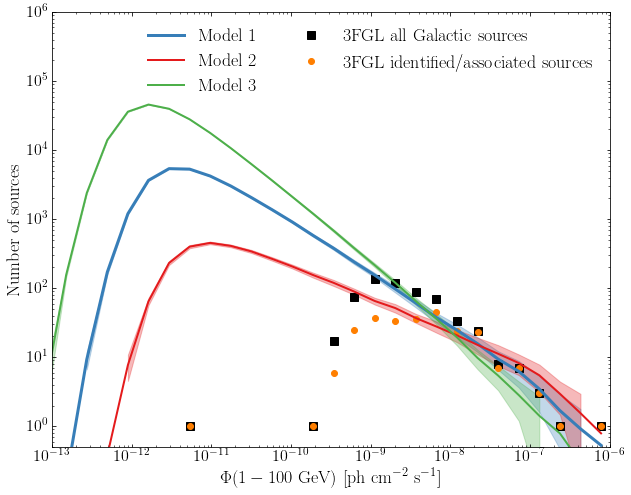

In [12]:
f,ax = plt.subplots(1,figsize=(10,8))
bins_mean = bins_3fgl_mean
hist_norm = hist_3fgl
mod = 1
for op in [op1,op2,op3]:
    hist_mean,hist_min,hist_max = op[0]
    options = op[4]
    hist_min = hist_min.astype('float')
    hist_min[hist_min==0]=1e-5
    N,a,Lmin = options[0:3]
    if N==29000:
        lw=3
    else:
        lw =2 
    line,=ax.loglog(bins_mean,hist_mean,label=r'Model %s'%(mod),lw=lw)
    color=line.get_color()
    ax.fill_between(bins_mean,hist_min,hist_max,where=((hist_min >0)&(hist_max>0)),alpha=0.3,color=color)
    mod +=1
    ax.set_yscale('log',nonposy='clip')
    ax.set_xlim([1e-13,1e-6])
    ax.set_ylim([5e-1,1e6])
    ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=16)
    ax.set_ylabel(r"Number of sources",fontsize=18)
    ax.set_xlabel(r"$\Phi(1-100 \ \rm GeV) \ [\rm ph \ cm^{-2}\ s^{-1}]$",fontsize=18)
    
ax.loglog(bins_mean,hist_norm,marker='s',label='3FGL all Galactic sources',ls='',ms=8,color='k',zorder=1)
# ax.loglog(bins_mean,hist_3fgl_snr,marker='v',label='3FGL SNR/PWN',ls='',ms=5,color=c1,zorder=1)
ax.loglog(bins_mean,hist_3fgl_ass,marker='o',label='3FGL identified/associated sources',ls='',ms=6,color=c5,zorder=1)

ax.legend(frameon=False,loc=1,fontsize=18,ncol=2)
plt.savefig('hist_3mod.pdf',bbox_inches='tight')

# Profiles

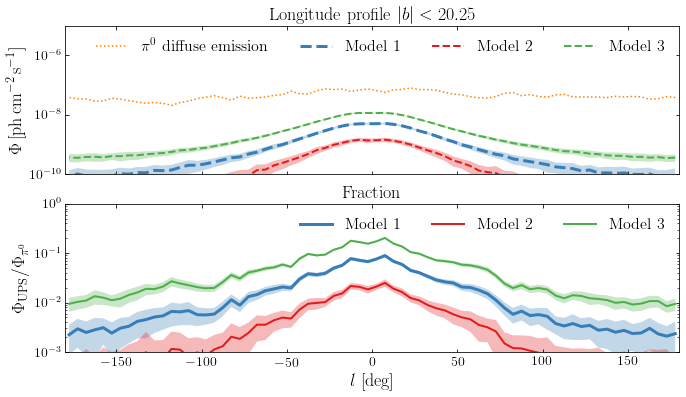

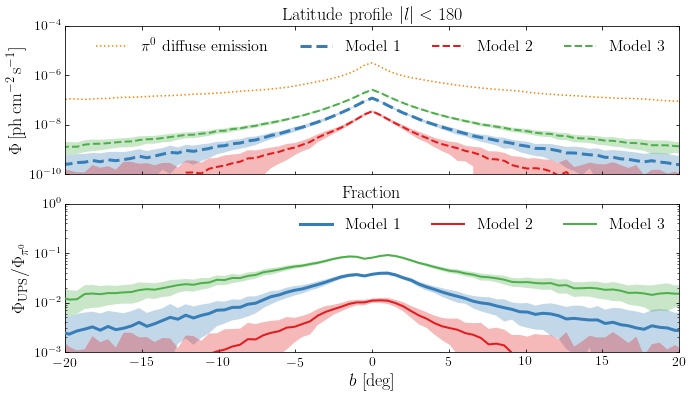

In [13]:
plot_lb_profile([op1,op2,op3],save=True)

# Energy dependence

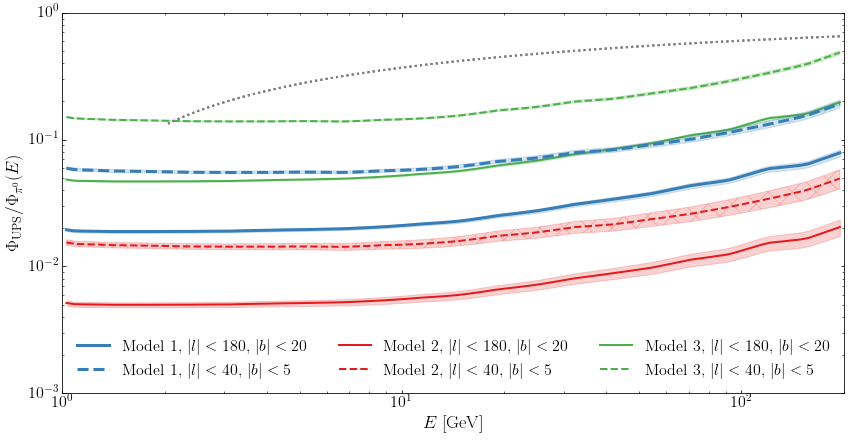

In [14]:
f,ax = plt.subplots(1,figsize=(14,7))
mpl.rcParams['axes.color_cycle'] = [c2,c6,c3,c4,c5,c1,c7,c8,c9]
mod = 1
for op in [op1,op2,op3]:
    fracmean,fracmin,fracmax = op[1]
    options = op[4]
    E = options[5]
    Emean = (E[1:]+E[:-1])/2.
    N,a,Lmin = options[:3]
    if N==29000:
        lw = 3
        zorder = 88
    else:
        lw=2
        zorder = 1
    line, = ax.plot(Emean,fracmean[0],label=r'Model %s, $|l| < %s$, $|b|<%s$'%(mod,lb[0][1],lb[0][0]),lw=lw,zorder=zorder)
    c = line.get_color()
    ax.fill_between(Emean,fracmin[0],fracmax[0],alpha=0.2,color=c,zorder=zorder)
#     ax.set_title(r"$|l| < %s$, $|b|<%s$"%(lb[0][1],lb[0][0]),fontsize=18)
    
    line, = ax.plot(Emean,fracmean[-1],label=r'Model %s, $|l| < %s$, $|b|<%s$'%(mod,lb[-1][1],lb[-1][0]),color=c,ls='--',lw=lw,zorder=zorder)
    ax.fill_between(Emean,fracmin[-1],fracmax[-1],alpha=0.2,color=c,hatch='x',zorder=zorder)
#     ax.set_title(r"$|l| < %s$, $|b|<%s$"%(lb[-1][1],lb[-1][0]),fontsize=18)
    
    ax.plot(Emean[Emean>2],1-(Emean[Emean>2]/1.)**-0.2,ls=':',color='grey',lw=2)
#     ax.plot(Emean[Emean>2],1-(Emean[Emean>2]/1.)**-0.1,ls=':',color='grey',lw=2)
    ax.legend(frameon=False,fontsize=16,loc=0,ncol=3)
    mod +=1
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([1e-3,1])
    ax.set_xlim([1,200])
    ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=16)
    ax.set_ylabel(r"$\Phi_{\rm UPS}/\Phi_{\pi^0}(E)$",fontsize=18)
    ax.set_xlabel(r"$E$ [GeV]",fontsize=18)
plt.savefig('UPS_E_1plot.pdf',bbox_inches='tight')

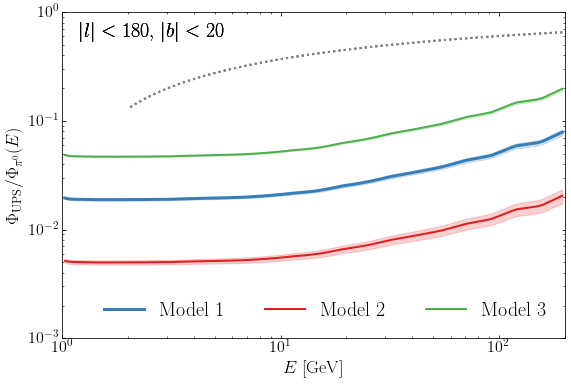

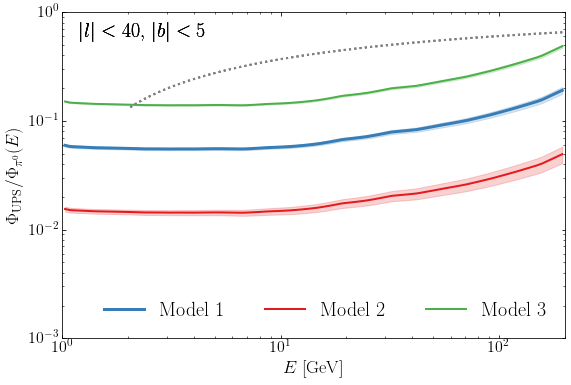

In [15]:
f,ax1 = plt.subplots(1,figsize=(9,6))
f2,ax2= plt.subplots(1,figsize=(9,6))
mpl.rcParams['axes.color_cycle'] = [c2,c6,c3,c4,c5,c1,c7,c8,c9]
mod = 1
for op in [op1,op2,op3]:
    fracmean,fracmin,fracmax = op[1]
    options = op[4]
    E = options[5]
    Emean = (E[1:]+E[:-1])/2.
    N,a,Lmin = options[:3]
    if N==29000:
        lw = 3
        zorder = 88
    else:
        lw=2
        zorder = 1

    line, = ax1.plot(Emean,fracmean[0],label=r'Model %s'%mod,lw=lw,zorder=zorder)
    c = line.get_color()
    ax1.fill_between(Emean,fracmin[0],fracmax[0],alpha=0.2,color=c,zorder=zorder)
    ax1.text(1.2,0.6,r"$|l| < %s$, $|b|<%s$"%(lb[0][1],lb[0][0]),fontsize=20)
    
    line, = ax2.plot(Emean,fracmean[-1],label=r'Model %s'%mod,color=c,ls='-',lw=lw,zorder=zorder)
    ax2.fill_between(Emean,fracmin[-1],fracmax[-1],alpha=0.2,color=c,zorder=zorder)
    ax2.text(1.2,0.6,r"$|l| < %s$, $|b|<%s$"%(lb[-1][1],lb[-1][0]),fontsize=20)
    
    ax1.plot(Emean[Emean>2],1-(Emean[Emean>2]/1.)**-0.2,ls=':',color='grey',lw=2)
    ax2.plot(Emean[Emean>2],1-(Emean[Emean>2]/1.)**-0.2,ls=':',color='grey',lw=2)
    ax1.legend(frameon=False,fontsize=20,loc=4,ncol=3)
    ax2.legend(frameon=False,fontsize=20,loc=4,ncol=3)

    mod +=1
    for ax in [ax1,ax2]:
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylim([1e-3,1])
        ax.set_xlim([1,200])
        ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=16)
        ax.set_ylabel(r"$\Phi_{\rm UPS}/\Phi_{\pi^0}(E)$",fontsize=18)
        ax.set_xlabel(r"$E$ [GeV]",fontsize=18)
    
# f.savefig('UPS_E_plot_all.pdf',bbox_inches='tight')
# f2.savefig('UPS_E_plot_inner.pdf',bbox_inches='tight')

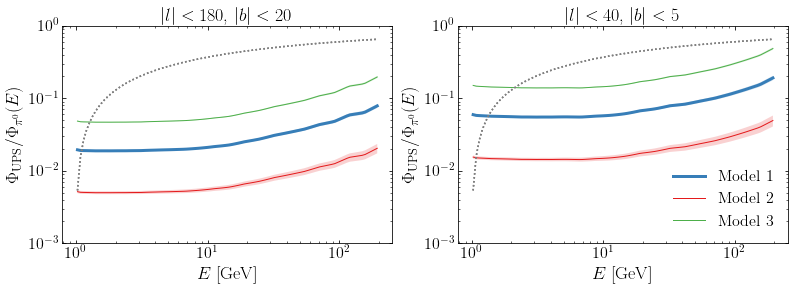

In [16]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(13,4))
mpl.rcParams['axes.color_cycle'] = [c2,c6,c3,c4,c5,c1,c7,c8,c9]
mod = 1
for op in [op1,op2,op3]:
    "Plot fraction UPS with output ave_sim"
    fracmean,fracmin,fracmax = op[1]
    options = op[4]
    E = options[5]
    Emean = (E[1:]+E[:-1])/2.
    N,a,Lmin = options[:3]
    if N==29000:
        lw = 3
    else:
        lw=1
    
    line, = ax1.loglog(Emean,fracmean[0],label=r'Model %s'%mod,lw=lw,zorder=1)
    ax1.fill_between(Emean,fracmin[0],fracmax[0],alpha=0.2)
    ax1.set_title(r"$|l| < %s$, $|b|<%s$"%(lb[0][1],lb[0][0]),fontsize=18)
    
    line, = ax2.loglog(Emean,fracmean[-1],label=r'Model %s'%mod,lw=lw,zorder=1)
    ax2.fill_between(Emean,fracmin[-1],fracmax[-1],alpha=0.2)
    ax2.set_title(r"$|l| < %s$, $|b|<%s$"%(lb[-1][1],lb[-1][0]),fontsize=18)
    ax1.loglog(Emean,1-(Emean/1.)**-0.2,ls=':',color='grey')
    ax2.loglog(Emean,1-(Emean/1.)**-0.2,ls=':',color='grey')
    ax2.legend(frameon=False,fontsize=16,loc=0)
    mod +=1
    for ax in [ax1,ax2]:
        ax.set_ylim([1e-3,1])
        ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=16)
        ax.set_ylabel(r"$\Phi_{\rm UPS}/\Phi_{\pi^0}(E)$",fontsize=18)
        ax.set_xlabel(r"$E$ [GeV]",fontsize=18)

# plt.savefig('fraction_2sky_3mod.pdf',bbox_inches='tight')